In [21]:
import os
os.chdir(os.getcwd() + '/..')

In [22]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
from iss.tools.config import Config
import pandas as pd
import datetime as dt
import time
import numpy as np
import os
import re
import PIL
from iss.data.CollectionManager import CollectionManagerFromDirectory

In [24]:
cfg = Config()
dir = os.path.join(cfg.project_dir, cfg.get('directory')['collections'])

In [25]:
collection = CollectionManagerFromDirectory(dir = dir, config = cfg)

In [26]:
collection.count().volumes

{'total': 13625}

In [27]:
collection.populateDirectories()

### test generator

In [9]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""
import keras

In [10]:
datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale = 0
)

In [11]:
train_generator = datagen.flow_from_directory(
    collection.dir_valid+'/..',
    target_size=(45, 80),
    color_mode='rgb',
    classes=None,
    class_mode='input',
    batch_size=24, 
    shuffle=True,
    seed=None,
    save_to_dir=None,
    save_prefix='',
    save_format='jpg',
    follow_links=False,
    subset=None,
    interpolation='nearest'
)
np_arr_o = train_generator.next()[1]

Found 1363 images belonging to 1 classes.


In [14]:
np_arr_o.shape

(24, 45, 80, 3)

In [208]:
np_arr_o

array([[[[   9.,   20.,   26.],
         [   9.,   20.,   26.],
         [   9.,   20.,   26.],
         ..., 
         [   5.,    5.,    5.],
         [   5.,    5.,    5.],
         [   5.,    5.,    5.]],

        [[   9.,   20.,   26.],
         [   9.,   20.,   26.],
         [   9.,   20.,   26.],
         ..., 
         [   5.,    5.,    5.],
         [   5.,    5.,    5.],
         [   5.,    5.,    5.]],

        [[  10.,   21.,   27.],
         [  10.,   21.,   27.],
         [  10.,   21.,   27.],
         ..., 
         [   5.,    5.,    5.],
         [   5.,    5.,    5.],
         [   5.,    5.,    5.]],

        ..., 
        [[ 170.,  173.,  224.],
         [ 171.,  174.,  225.],
         [ 170.,  173.,  224.],
         ..., 
         [ 136.,  142.,  216.],
         [ 136.,  142.,  216.],
         [ 136.,  142.,  216.]],

        [[ 153.,  156.,  207.],
         [ 154.,  157.,  208.],
         [ 154.,  157.,  208.],
         ..., 
         [ 136.,  142.,  216.],
       

In [15]:
#np_arr = np.reshape(np_arr_o, (720, 1280, 3))
#np_arr[0][0]
np_arr = np_arr_o.astype('uint8')

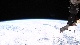

In [16]:
PIL.Image.fromarray(np_arr[0], 'RGB')

In [17]:
img = Image.open('/home/jovyan/work/data/processed/models/autoencoder/valid/k/20170416-013001.jpg')
img.load()
data = np.asarray(img, dtype=np.uint8)

NameError: name 'Image' is not defined

In [18]:
data.shape

NameError: name 'data' is not defined

In [224]:
data[0]

array([[ 9, 20, 26],
       [ 9, 20, 26],
       [ 9, 20, 26],
       ..., 
       [ 5,  5,  5],
       [ 5,  5,  5],
       [ 5,  5,  5]], dtype=uint8)

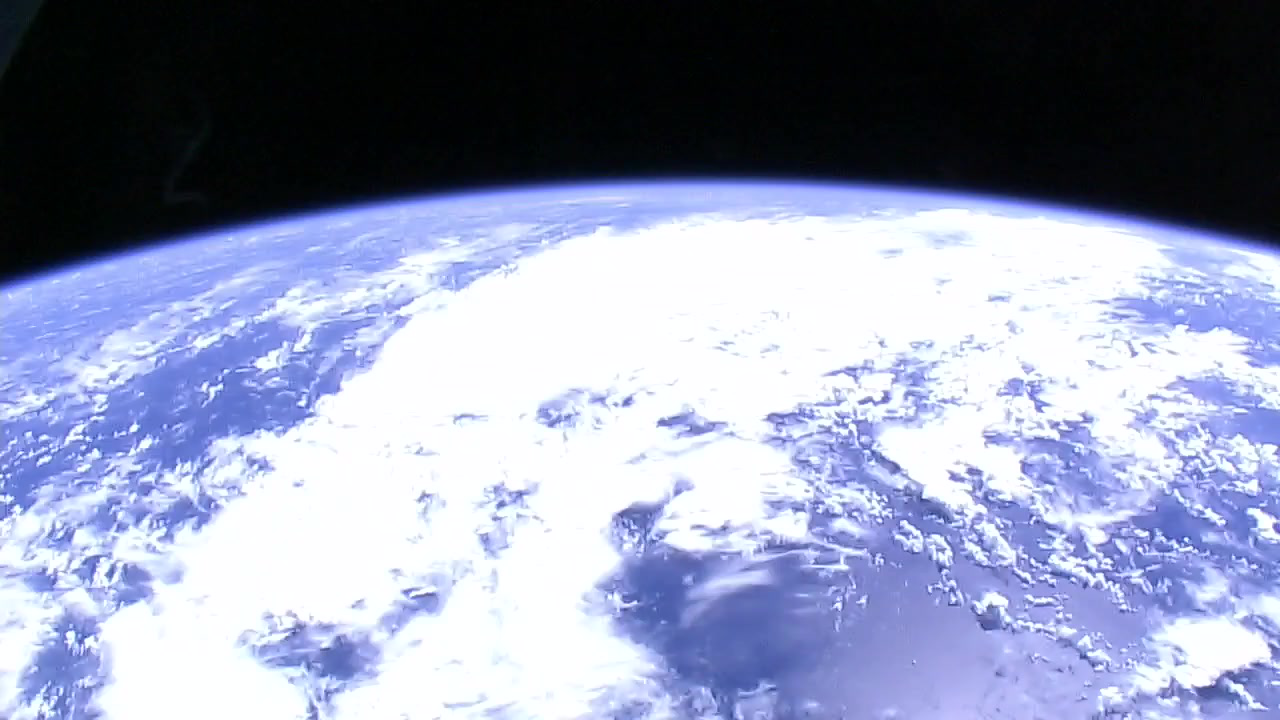

In [225]:
PIL.Image.fromarray(data, 'RGB')

### Test autoencoder

In [18]:
# https://blog.keras.io/building-autoencoders-in-keras.html
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Reshape, Flatten
from keras.models import Model
from keras import backend as K

input_img = Input((45, 80, 3))  # adapt this if using `channels_first` image data format

x = Conv2D(1, (3, 3), activation='relu', padding='valid', name = "enc_conv_1", strides = 2)(input_img)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (11, 20, 8) i.e. 480-dimensional

x = Conv2D(1, (3, 3), activation='relu', padding = 'same', name = "dec_conv_1")(encoded)
x = UpSampling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(10800, input_shape = (48, 80, 1))(x)
decoded = Reshape((45, 80, 3))(x)
#  decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same', name = "dec_conv_4")(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [19]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 45, 80, 3)         0         
_________________________________________________________________
enc_conv_1 (Conv2D)          (None, 22, 39, 1)         28        
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 11, 20, 1)         0         
_________________________________________________________________
dec_conv_1 (Conv2D)          (None, 11, 20, 1)         10        
_________________________________________________________________
up_sampling2d_8 (UpSampling2 (None, 22, 40, 1)         0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 880)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 10800)             9514800   
__________

In [20]:
autoencoder.fit_generator(train_generator, steps_per_epoch=1000, epochs = 2)

Epoch 1/2
 174/1000 [====>.........................] - ETA: 4:53 - loss: -1657.1020

KeyboardInterrupt: 